## Compare PGS scores
Compare output from the different PGS prediction models.

In [3]:
import matplotlib
matplotlib.use('nbagg')

In [4]:
%matplotlib inline

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
matplotlib.rc_file_defaults()

In [7]:
def ztransform(x):
    '''
    Return input normalized to zero mean and unit variance
    
    Parameters
    ----------
    x: ndarray
    
    Returns
    -------
    ndarray
    '''
    return (x - x.mean()) / x.std()

In [8]:
def get_pheno_list(phenodata, scores):
    '''
    For whatever reason the computed scores may include different pairs 
    of IID & FID than exist in the phenotype file. This function 
    fills in a NaN value for missing phenotype values

    Parameters
    ----------
    phenodata: DataFrame
        Phenotype dataframe with columns ['IID', 'FID', <phenotype>]
    scores: DataFrame
        PGS dataframe with columns ['IID', 'FID', 'score']

    Returns
    -------
    DataFrame
        Phenotype dataframe with columns ['IID', 'FID', <phenotype>]
    '''
    pheno_list = []
    for fid, iid in scores[['FID', 'IID']].values:
        row = phenodata[(phenodata['FID'] == fid) & (phenodata['IID'] == iid)]
        # fill in NaN if value is missing
        if row.size == 0:
            row = pd.DataFrame(data=[['FID', 'IID', np.nan]], 
                               columns=phenodata.columns)
        pheno_list += [row]
    return pd.concat(pheno_list, ignore_index=True)

In [9]:
# make some guesses where reference data is located in relation to host
if os.path.isdir('/REF'):  # mounted dir on container
    REF = '/REF'
elif 'REFERENCE' in os.environ:
    REF = os.environ['REFERENCE']
else:
    REF = os.path.join('..', 'reference')

In [10]:
# Load phenotypes
Pheno_file = os.path.join(REF, 'examples/prsice2/EUR.height')
pheno = pd.read_csv(Pheno_file, delim_whitespace=True)
pheno_type = pheno.columns[2]

Text(0, 0.5, 'Height')

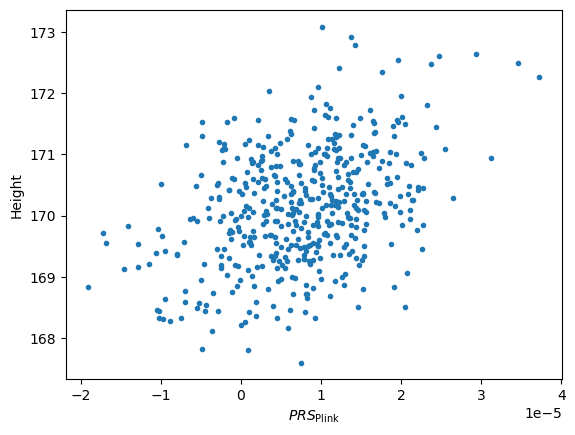

In [11]:
# plink
Output_dir = 'PGS_plink'
Data_prefix = 'EUR'

# scores
scores_plink = pd.read_csv(os.path.join(Output_dir, 'test.score'), sep=' ')

# extract valids
pheno_list = get_pheno_list(pheno, scores_plink)

# plot SCORE vs measured HEIGHT
plt.plot(scores_plink['score'], pheno_list[pheno_type], '.')
plt.xlabel('$PRS_\mathrm{Plink}$')
plt.ylabel(pheno_type)

Text(0, 0.5, 'Height')

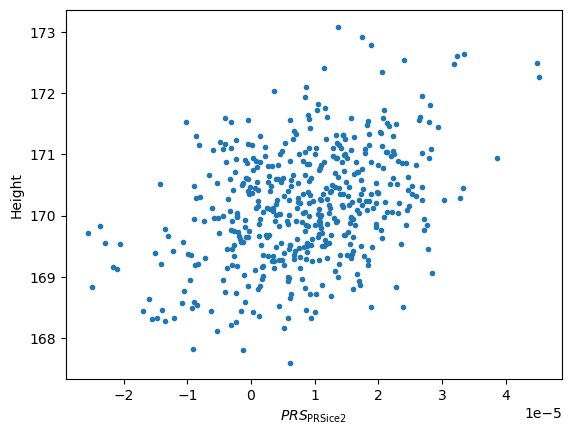

In [12]:
# PRSice-2
Output_dir = 'PGS_prsice2'
Data_prefix = 'EUR'

# scores
scores_prsice2 = pd.read_csv(os.path.join(Output_dir, 'test.score'), sep=' ')

# extract valids
pheno_list = get_pheno_list(pheno, scores_prsice2)

# plot SCORE vs HEIGHT
plt.plot(scores_prsice2['score'], pheno_list[pheno_type], '.')
plt.xlabel('$PRS_\mathrm{PRSice2}$')
plt.ylabel(pheno_type)

In [13]:
pd.read_csv(os.path.join(Output_dir, 'test.score'), delim_whitespace=True)

,FID,IID,score
0,HG00096,HG00096,-0.000021
1,HG00097,HG00097,0.000012
2,HG00099,HG00099,-0.000003
3,HG00101,HG00101,0.000010
4,HG00102,HG00102,0.000019
...,...,...,...
478,NA20822,NA20822,0.000013
479,NA20826,NA20826,0.000004
480,NA20827,NA20827,0.000013
481,NA20828,NA20828,0.000016


Text(0, 0.5, 'Height')

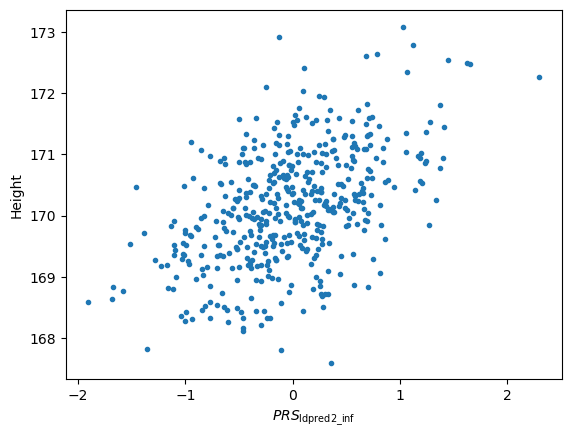

In [16]:
# LDpred2 infinitesimal model
Output_dir = 'PGS_LDpred2_inf'

# scores
scores_ldpred2_inf = pd.read_csv(os.path.join(Output_dir, 'test.score'), delim_whitespace=True)

# extract valids
pheno_list = get_pheno_list(pheno, scores_ldpred2_inf)

# plot SCORE vs HEIGHT
plt.plot(scores_ldpred2_inf['score'], pheno_list[pheno_type], '.')
plt.xlabel('$PRS_\mathrm{ldpred2\_inf}$')
plt.ylabel(pheno_type)

Text(0, 0.5, 'Height')

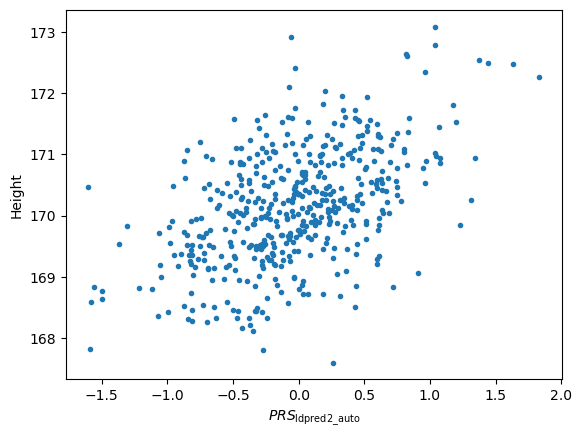

In [17]:
# LDpred2 automatic model
Output_dir = 'PGS_LDpred2_auto'

# scores
scores_ldpred2_auto = pd.read_csv(os.path.join(Output_dir, 'test.score'), delim_whitespace=True)

# extract valids
pheno_list = get_pheno_list(pheno, scores_ldpred2_inf)

# plot SCORE vs HEIGHT
plt.plot(scores_ldpred2_auto['score'], pheno_list[pheno_type], '.')
plt.xlabel('$PRS_\mathrm{ldpred2\_auto}$')
plt.ylabel(pheno_type)

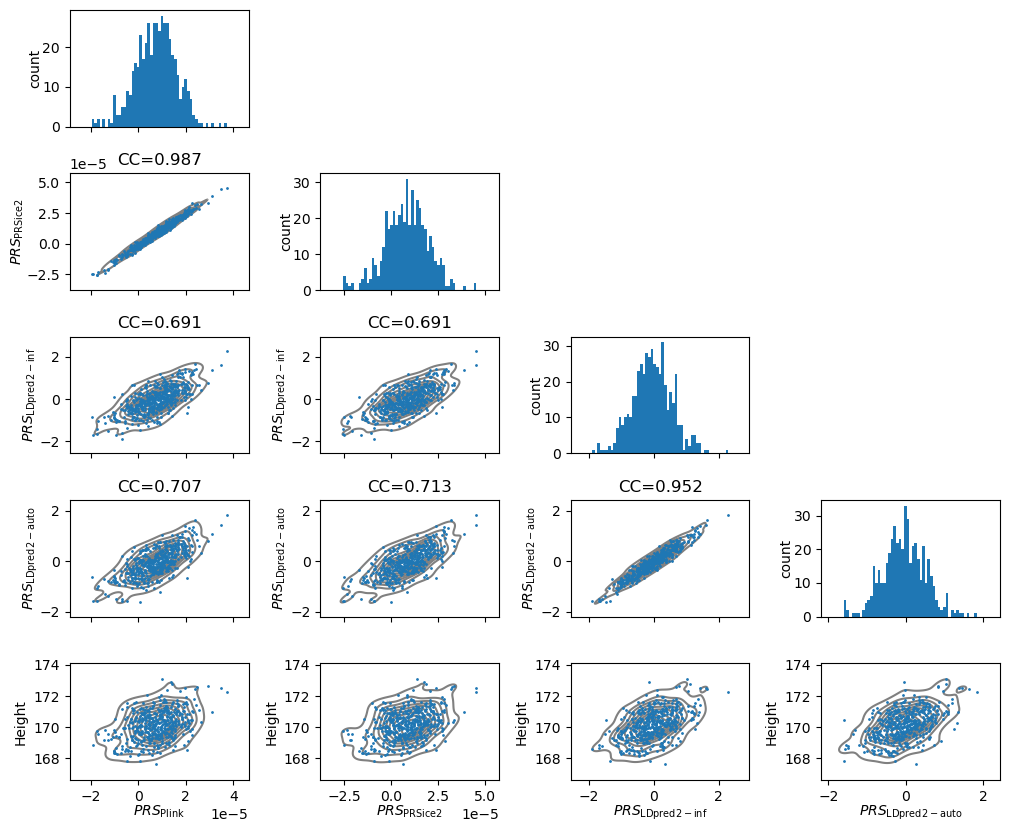

In [18]:
# compare scores and distributions
all_scores = [scores_plink, scores_prsice2, scores_ldpred2_inf, scores_ldpred2_auto]
labels = [r'$PRS_\mathrm{Plink}$', r'$PRS_\mathrm{PRSice2}$', 
          r'$PRS_\mathrm{LDpred2-inf}$', r'$PRS_\mathrm{LDpred2-auto}$']

fig, axes = plt.subplots(len(all_scores) + 1, len(all_scores), figsize=(12, 10), sharex='col')
fig.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(len(all_scores)):
    y = all_scores[i]['score']
    for j in range(len(all_scores)):
        x = all_scores[j]['score']
        if i < j:
            axes[i, j].set_visible(False)
        elif i==j:
            axes[i, j].hist(x, bins=51)
            axes[i, j].set_ylabel('count', labelpad=0)
        elif i > j:
            sns.kdeplot(x=x, 
                        y=y,
                        ax=axes[i, j],
                        color='gray')
            axes[i, j].plot(x, y, 'C0.', ms=2)
            axes[i, j].set_ylabel(labels[i], labelpad=0)
            axes[i, j].set_title(f'CC={np.corrcoef(x, y)[1, 0]:.3f}')

# phenotype vs. prs
y = pheno_list[pheno_type]
for j in range(len(all_scores)):
    ax = axes[-1, j]
    x = all_scores[j]['score']
    sns.kdeplot(x=x, 
                y=y,
                ax=ax,
                color='gray')
    ax.plot(x, y, '.', ms=2)
    ax.set_xlabel(labels[j], labelpad=0)
    ax.set_ylabel(pheno_type)
    

In [ ]:
# normalized scores
fig, axes = plt.subplots(len(all_scores) + 1, len(all_scores), figsize=(12, 10), sharex='col')
fig.subplots_adjust(wspace=0.4, hspace=0.4)
fig.suptitle(f'normalized scores ($\mu=0, \sigma^2=1$)')

for i in range(len(all_scores)):
    y = ztransform(all_scores[i]['score'])
    for j in range(len(all_scores)):
        x = ztransform(all_scores[j]['score'])
        if i < j:
            axes[i, j].set_visible(False)
        elif i==j:
            axes[i, j].hist(x, bins=51)
            axes[i, j].set_ylabel('count', labelpad=0)
        elif i > j:
            sns.kdeplot(x=x, 
                        y=y,
                        ax=axes[i, j],
                        color='gray')
            axes[i, j].plot(x, y, 'C0.', ms=2)
            axes[i, j].set_ylabel(labels[i], labelpad=0)
            axes[i, j].set_title(f'CC={np.corrcoef(x, y)[1, 0]:.3f}')

# height vs. prs
y = pheno_list['Height']
for j in range(len(all_scores)):
    ax = axes[-1, j]
    x = ztransform(all_scores[j]['score'])
    sns.kdeplot(x=x, 
                y=y,
                ax=ax,
                color='gray')
    ax.plot(x, y, '.', ms=2)
    ax.set_xlabel(labels[j], labelpad=0)
    ax.set_ylabel('Height (cm)')
    
fig.savefig('vis_pgs_normalized_scores.pdf')